----

### Simple Math NN

"Neural networks aren't built to add two floating points together"

##### Challenge 1: 
  
--   Add two floats together
  
##### Challenge 2: 
  
--  x1 and x2 are floats. x3:x7 is a onehot_encoding of an operation (+, -, (0.4*x1 + 0.1 * x2), return x1, return x2)
  
--   based on the operation given by x3, perform this calculation on x1 and x2
  
--   see data_generation() function for implementation of one hot encoding

#### Models tested

1. Simple Linear model

2. Non-Linear Model

3. Non-Linear Model with residual link

4. Model that projects (x1 and x2) to 5 outputs, and projects x3 to 5 outputs (termed the 'gate'), and multiplies values together

5. Generalised version of 4.,: projects x1,x2 and x3 twice - semantically one of the projections is a gate and one is for the values. Multiplies outputs of projections together

#### Methodology

Each model ran 5 times on each challenge, graphs show the log of the MAE.

Each model ran for 100k epochs (batch size 32, lr=1e-2) then for 250k epochs (batch size 128, lr=1e-6)

-- Hyper-parameters chosen based on optimum performance for Linear Model on challenge 1.

#### Conclusions

1. Residual connections speeds up learning of addition of two floats, or performing mathematical operations in general.

2. Generalised model that projects values twice, with one semantically can be thought of as 'gate' performs better than other models.

3. Gate should not include an activation layer (see final section)

In [1]:
!pip install -U scikit-learn

In [13]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [135]:
def data_generation(bs=256, add_only=False):
    x1 = np.round(np.random.uniform(-1,1, bs),decimals=4)
    x2 = np.round(np.random.uniform(-1,1, bs), decimals=4)
    x3_ = np.argmax(np.random.multinomial(n=1, pvals=[0.2] *5, size=(bs, )),-1)
    x3 = np.eye(5)
    sign= x3[x3_]
    
    def output(x1, x2, x3):
        if add_only:
            return x1 + x2
        if x3 == 0:
            return x1+x2
        elif x3 == 1:
            return x1-x2
        elif x3 == 2:
            return x1 *0.4 + 1 + x2*0.1
        elif x3==3:
            return x1
        else:
            return x2
            # return (x1**2 + x2**2)**0.5
    y = list(map(output, x1,x2, x3_))
    return [np.concatenate(
        [np.reshape(x1,(-1,1)),
         np.reshape(x2,(-1,1)),
         sign
        ],-1),y]

In [365]:
def training_loop(model, optim, epochs, add_only, batch_size=4096, loss_func='mse'):
    mses=[]
    maes =[]
    for e in tqdm(range(epochs), leave=False):
        x, y = data_generation(batch_size, add_only)
        x = torch.tensor(x).float()
        y= torch.tensor(y).float()
        y_hat = model(x)
        if loss_func=='mae':
            loss = torch.mean(torch.abs(y-y_hat))
            mae = loss.detach().numpy()
            mse = torch.mean((y-y_hat)**2)
            mse = mse.detach().numpy()
        else:
            loss = mse = torch.mean((y-y_hat)**2)
            mse = mse.detach().numpy()
            mae = np.mean(torch.abs(y-y_hat).detach().numpy())
        loss.backward()
        optim.step(); optim.zero_grad()
        mses.append(mse)
        maes.append(mae)
    return model, mses, maes

In [366]:
def rolling_average(arr, window_size=1000):
    cumsum = np.cumsum(arr)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

In [371]:
def experiment(Model_cls, add_only, trials=5):
    print("#---------RESULTS---------#")
    print("#-Last 1000 epochs avg MAE-#")
    plt.figure(figsize=(12,8))
    for i in range(trials):
        model = Model_cls()
        optim = torch.optim.Adam(model.parameters(), lr=1e-2)
        
        model, mses, maes1 = training_loop(model, optim, 100000, add_only = add_only, batch_size=32)
        
        optim2 = torch.optim.Adam(model.parameters(), lr=1e-6)
        model, mses, maes2 = training_loop(model, optim2, 250000, add_only = add_only, batch_size=128)
        
        plt.plot(np.log(rolling_average(maes1+maes2)+1e-12))
        print(f'Trial {i+1} avg MAE: {np.mean(rolling_average(maes2[-4000:])+1e-12)}')
    plt.show()
    
    return model, optim, maes, mses

In [372]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(7, 1)
        
    def forward(self, x):
        return torch.squeeze(self.fc(x))

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 8.690815178624689e-08


Trial 2 avg MAE: 8.485316982387303e-08


Trial 3 avg MAE: 8.373241655590391e-08


Trial 4 avg MAE: 8.513431737355859e-08


Trial 5 avg MAE: 8.744174806452065e-08


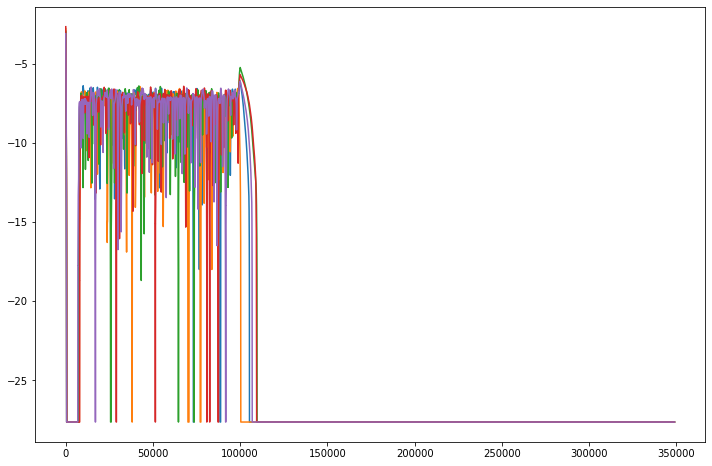

In [373]:
model_lin, optim_lin, maes, mses = experiment(LinearModel, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 0.3720327317714691


Trial 2 avg MAE: 0.3715105354785919


Trial 3 avg MAE: 0.3715253174304962


Trial 4 avg MAE: 0.3726728558540344


Trial 5 avg MAE: 0.37158459424972534


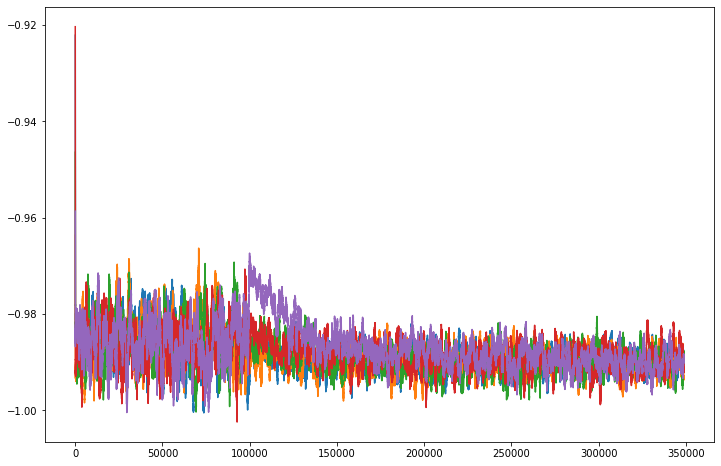

In [374]:
model_lin, optim_lin, maes, mses = experiment(LinearModel, add_only=False)

In [375]:
class NonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 3.3914770369847247e-07


Trial 2 avg MAE: 1.9284527752461145e-07


Trial 3 avg MAE: 4.437727625372645e-07


Trial 4 avg MAE: 5.926223138885689e-07


Trial 5 avg MAE: 1.4594097308417986e-07


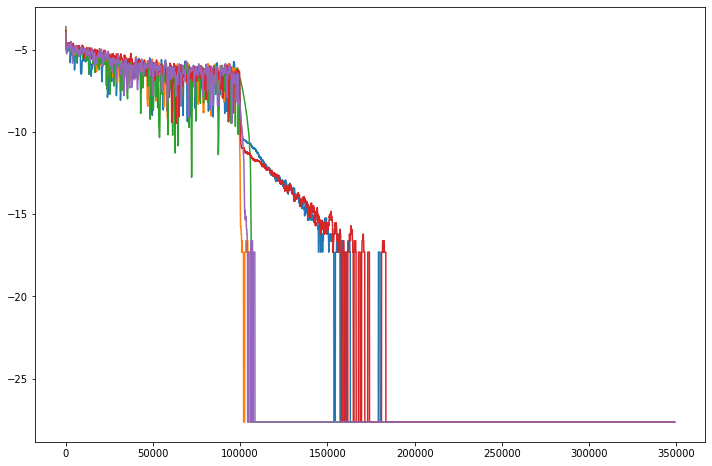

In [376]:
model, optim, maes, mses = experiment(NonLinearModel, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.1461368558229879e-05


Trial 2 avg MAE: 3.056623609154485e-05


Trial 3 avg MAE: 4.353973417892121e-05


Trial 4 avg MAE: 6.539301921293372e-06


Trial 5 avg MAE: 9.127475095738191e-07


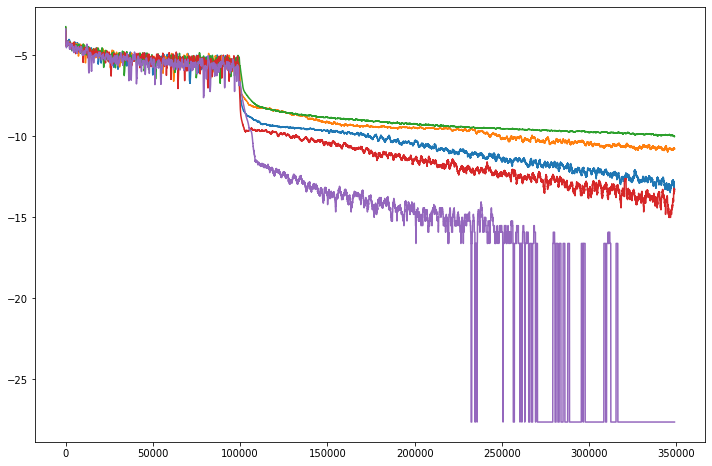

In [377]:
model, optim, maes, mses = experiment(NonLinearModel, add_only=False)

----

### Can a residual link help?

In [378]:
class NLResidualPostReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 15)
        self.fc2 = nn.Linear(22, 15)
        self.fc3 = nn.Linear(37, 1)
        
    def forward(self, x):
        x = torch.cat([x, nn.ReLU()(self.fc1(x))],-1)
        x = torch.cat([x, nn.ReLU()(self.fc2(x))], -1)
        x = self.fc3(x)
        return torch.squeeze(x)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 9.106785370249781e-08


Trial 2 avg MAE: 8.752076752216453e-08


Trial 3 avg MAE: 8.504280657462004e-08


Trial 4 avg MAE: 8.852877186882324e-08


Trial 5 avg MAE: 8.601492140769551e-08


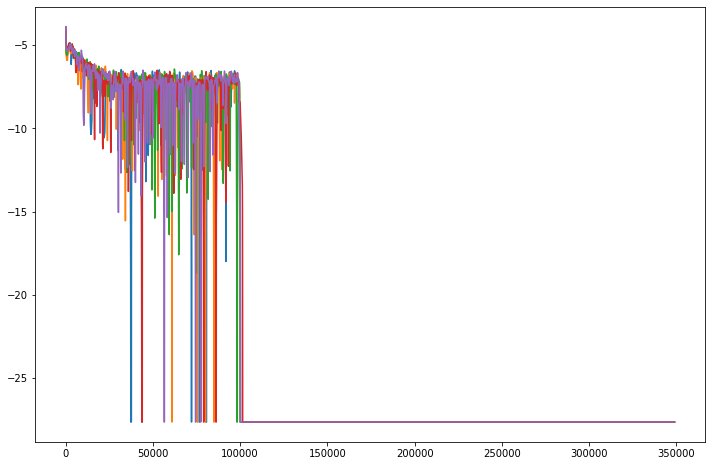

In [379]:
model, optim, maes, mses = experiment(NLResidualPostReLU, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 3.590913308926247e-07


Trial 2 avg MAE: 2.1641922103299294e-06


Trial 3 avg MAE: 3.5503174444784236e-07


Trial 4 avg MAE: 1.7074012248485815e-07


Trial 5 avg MAE: 1.7842870647655218e-07


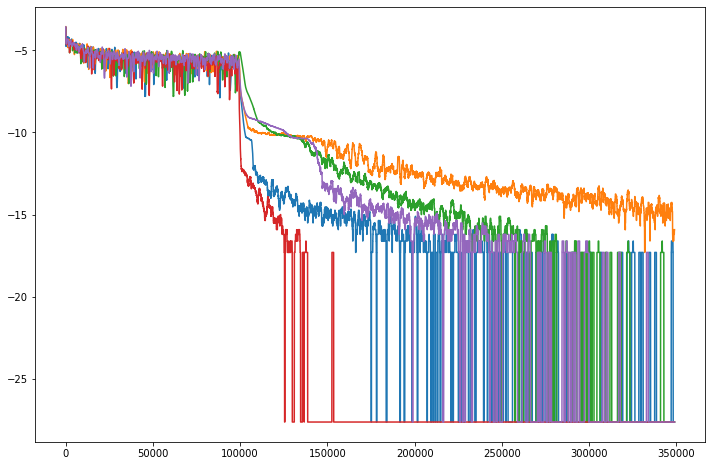

In [380]:
model, optim, maes, mses = experiment(NLResidualPostReLU, add_only=False)

----

#### A residual link allows higher performance on very simple task (just adding two numbers) but a modest improvement when the calculation can take many different mathematical forms.rolling_average

----

Can we improve on this by using the idea of a 'gate'... one part of the model that determines what type of calculation to do, and another part which performs the various calculations?

the Basic AddSub model uses a forward connection to multiply x1 and x2 to produce 5 outputs. It then has a gate input which takes the binary values to output which 'gate' to follow

In [381]:
class BasicAddSub(nn.Module):
    def __init__(self):
        super().__init__()
        self.gate = nn.Linear(5,5) #+ - * 1 2
        self.fc1 = nn.Linear(2,5)
    
    def __call__(self, x):
        values = x[:, :2]
        gate_input = x[: ,2: 7]
        gate_logits = self.gate(gate_input)
        gate = gate_logits
        return torch.sum(gate*self.fc1(values),-1)
        

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.1080157946707914e-07


Trial 2 avg MAE: 1.0949656115144535e-07


Trial 3 avg MAE: 1.1748543471412631e-07


Trial 4 avg MAE: 1.1228915042238441e-07


Trial 5 avg MAE: 1.1303303182330637e-07


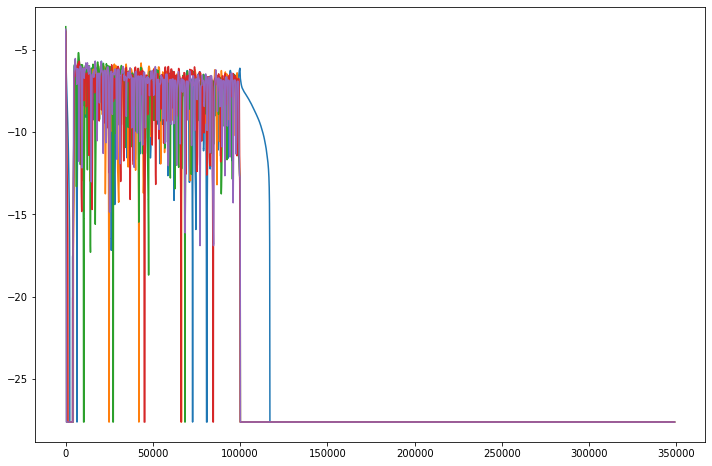

In [382]:
model, optim, maes, mses = experiment(BasicAddSub, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.6885360309970565e-07


Trial 2 avg MAE: 1.712924415642192e-07


Trial 3 avg MAE: 1.685298229858745e-07


Trial 4 avg MAE: 1.7569763599567523e-07


Trial 5 avg MAE: 1.8262147705172538e-07


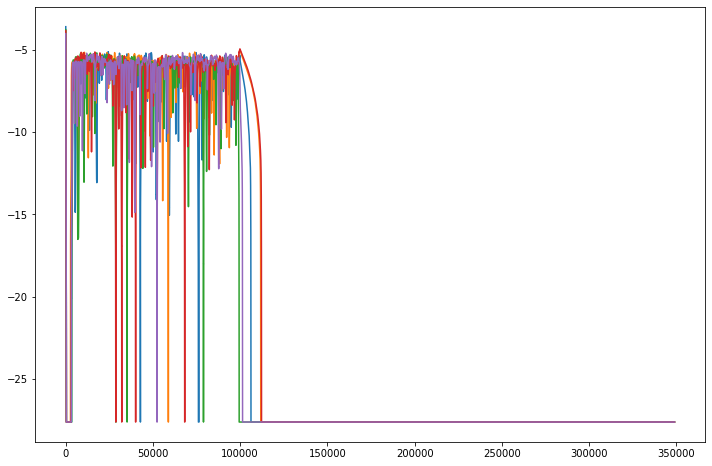

In [383]:
model, optim, maes, mses = experiment(BasicAddSub, add_only=False)

---

#### Using a multiplicative approach, we are able to form an effective gate

This alows us to achieve 100% on both the basic addition task and more cmplicated task of handling multiple basic mathematical operations

----

#### Is this generalisable?

Will a model that doesn't separate the input for us perform just as well?

In [384]:
class MoreGeneralisableAddSub(nn.Module):
    def __init__(self):
        super().__init__()
        self.gate = nn.Linear(7,5) #+ - * 1 2
        self.fc1 = nn.Linear(7,5)
    
    def __call__(self, x):
        gate = self.gate(x)
        output = self.fc1(x)
        return torch.sum(gate * output,-1)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.507102638242941e-07


Trial 2 avg MAE: 1.5178760293110827e-07


Trial 3 avg MAE: 1.4852197693926428e-07


Trial 4 avg MAE: 1.482332407931608e-07


Trial 5 avg MAE: 1.460431775512916e-07


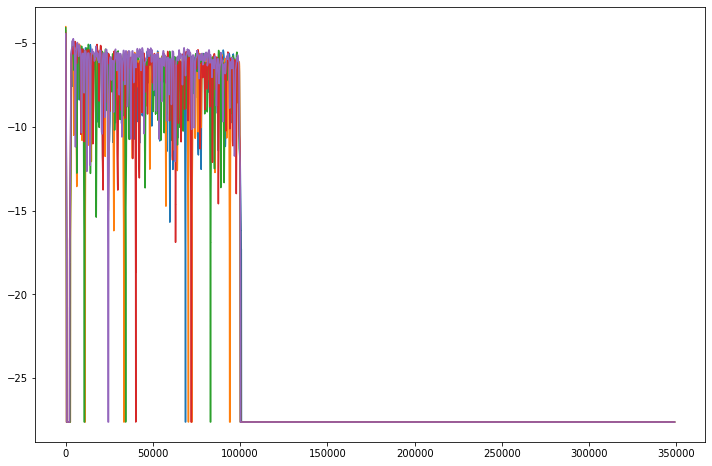

In [385]:
model, optim, maes, mses = experiment(MoreGeneralisableAddSub, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 2.2611210681589e-07


Trial 2 avg MAE: 2.2374916852641036e-07


Trial 3 avg MAE: 2.2166695146097481e-07


Trial 4 avg MAE: 2.1271291927860148e-07


Trial 5 avg MAE: 2.0135624367867422e-07


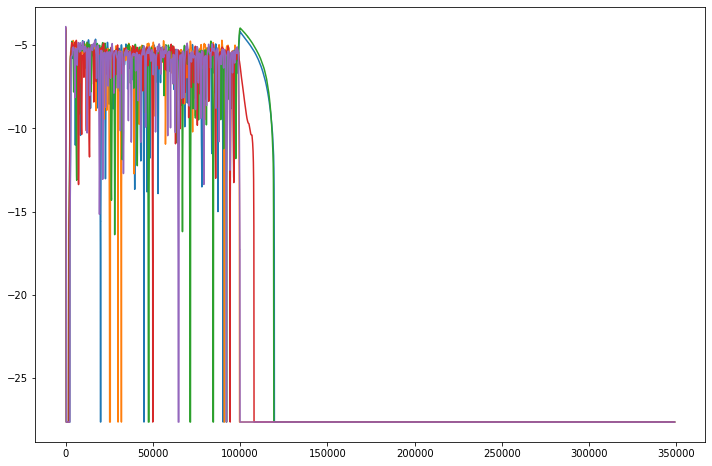

In [386]:
model, optim, maes, mses = experiment(MoreGeneralisableAddSub, add_only=False)

----

#### Do we achieve same/better/worse results if we apply an activation layer on one of the projections (the gate)

##### Conclusion: NO. Much worse

In [387]:
class GenAddSubWithActivation(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.gate = nn.Linear(7,5) #+ - * 1 2
        self.fc1 = nn.Linear(7,5)
        self.activation= activation
    
    def __call__(self, x):
        gate = self.activation()(self.gate(x))
        output = self.fc1(x)
        return torch.sum(gate * output,-1)

In [388]:
from functools import partial
relu_add_sub = partial(GenAddSubWithActivation, activation=nn.ReLU)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 0.00012230277934577316


Trial 2 avg MAE: 1.559100155645865e-07


Trial 3 avg MAE: 1.824932525096301e-07


Trial 4 avg MAE: 1.4357267730247258e-07


Trial 5 avg MAE: 1.4860729891097435e-07


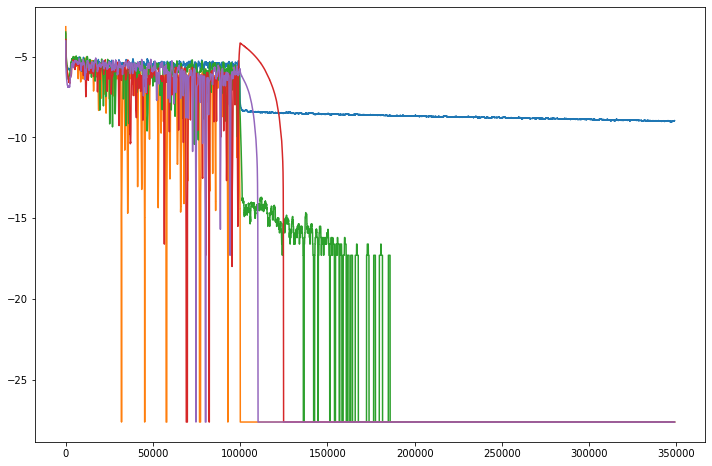

In [389]:
model, optim, maes, mses = experiment(relu_add_sub, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 2.1944123318462516e-07


Trial 2 avg MAE: 1.9447473675882065e-07


Trial 3 avg MAE: 8.396109478781e-06


Trial 4 avg MAE: 1.0001670034398558e-06


Trial 5 avg MAE: 0.00206321501173079


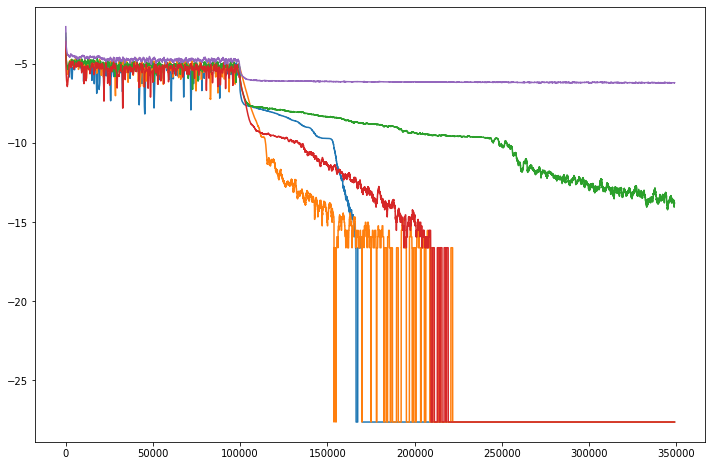

In [390]:
model, optim, maes, mses = experiment(relu_add_sub, add_only=False)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.8260326442032238e-06


Trial 2 avg MAE: 7.795323426762479e-07


Trial 3 avg MAE: 2.6715842977864668e-06


Trial 4 avg MAE: 2.274665575896506e-06


Trial 5 avg MAE: 9.05186971067451e-06


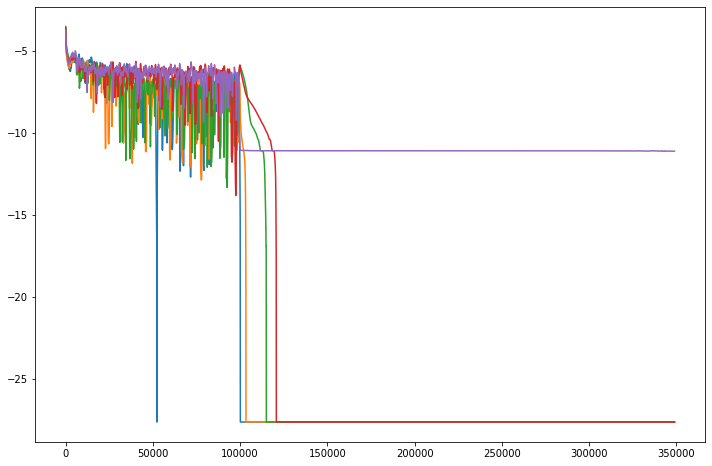

In [391]:
tanh_add_sub = partial(GenAddSubWithActivation, activation=nn.Tanh)
model, optim, maes, mses = experiment(tanh_add_sub, add_only=True)


#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.5538127229319798e-07


Trial 2 avg MAE: 1.7224232351509272e-07


Trial 3 avg MAE: 1.7020428799696674e-07


Trial 4 avg MAE: 1.7396716600615036e-07


Trial 5 avg MAE: 3.4462814824109955e-07


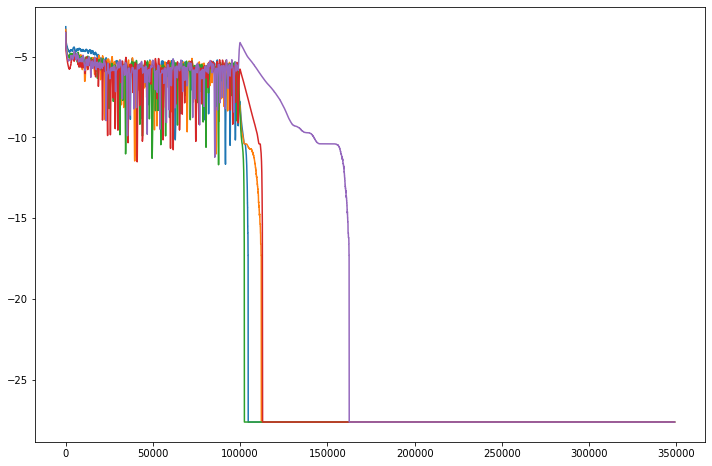

In [392]:
model, optim, maes, mses = experiment(tanh_add_sub, add_only=False)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.4846763463083334e-07


Trial 2 avg MAE: 9.80258482741192e-05


Trial 3 avg MAE: 1.9184567463526037e-06


Trial 4 avg MAE: 8.21367502794601e-05


Trial 5 avg MAE: 1.507212061824248e-07


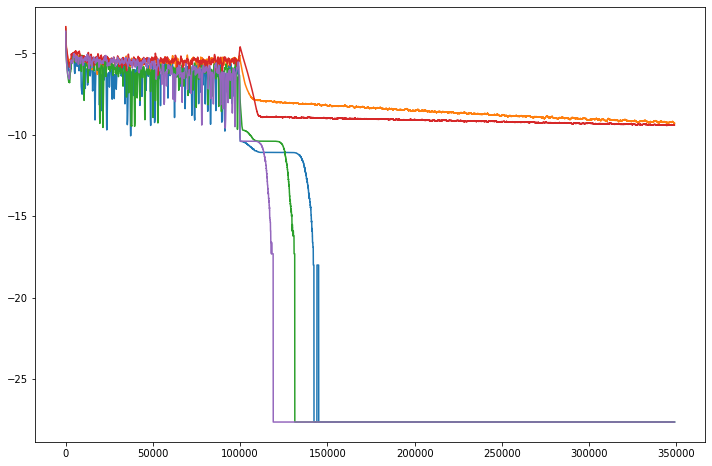

In [393]:
leak_relu_add_sub = partial(GenAddSubWithActivation, activation=nn.LeakyReLU)
model, optim, maes, mses = experiment(leak_relu_add_sub, add_only=True)


#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 4.404258220347401e-07


Trial 2 avg MAE: 2.25428652811388e-06


Trial 3 avg MAE: 4.9263973778579384e-05


Trial 4 avg MAE: 6.911750097060576e-05


Trial 5 avg MAE: 4.3487536458997056e-05


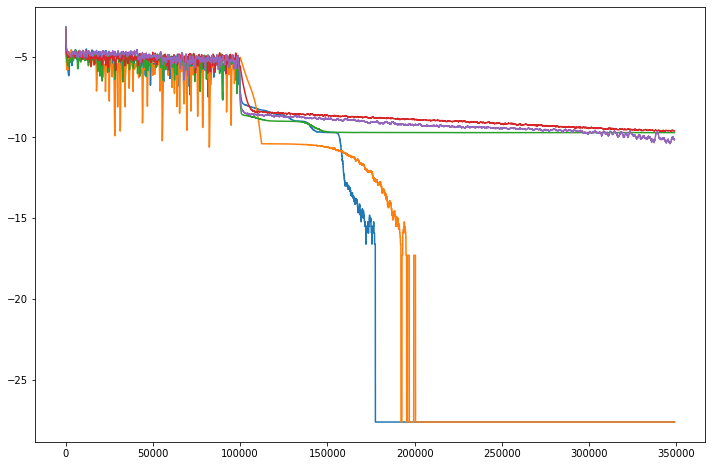

In [394]:
model, optim, maes, mses = experiment(leak_relu_add_sub, add_only=False)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 9.93341444655016e-08


Trial 2 avg MAE: 0.00010924728849204257


Trial 3 avg MAE: 2.2069468741392484e-06


Trial 4 avg MAE: 1.2336018698988482e-05


Trial 5 avg MAE: 7.140939715100103e-07


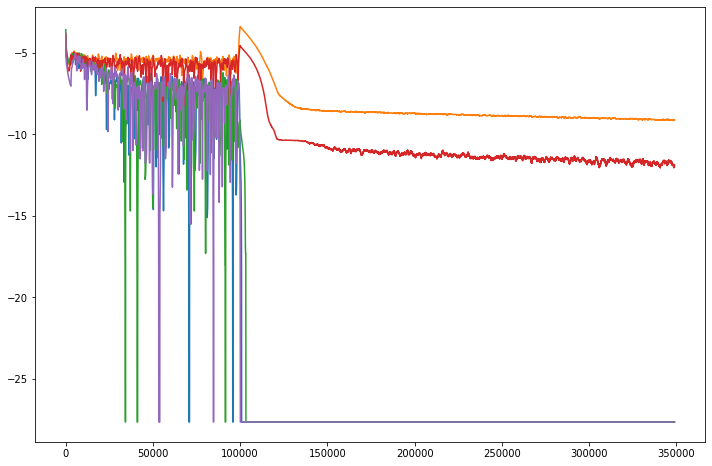

In [395]:
elu_add_sub = partial(GenAddSubWithActivation, activation=nn.ELU)
model, optim, maes, mses = experiment(elu_add_sub, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 2.2043316505460098e-07


Trial 2 avg MAE: 1.87627813375002e-06


Trial 3 avg MAE: 7.423703891618061e-07


Trial 4 avg MAE: 3.6550198956319946e-07


Trial 5 avg MAE: 2.77445337815152e-07


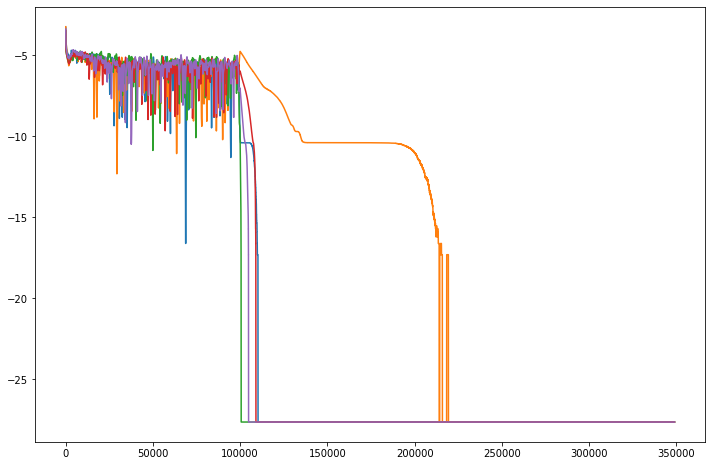

In [396]:
model, optim, maes, mses = experiment(elu_add_sub, add_only=False)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 4.980262815479364e-07


Trial 2 avg MAE: 4.4695607925859804e-07


Trial 3 avg MAE: 6.941623809098019e-08


Trial 4 avg MAE: 1.2498921933001839e-06


Trial 5 avg MAE: 2.1113370962666522e-07


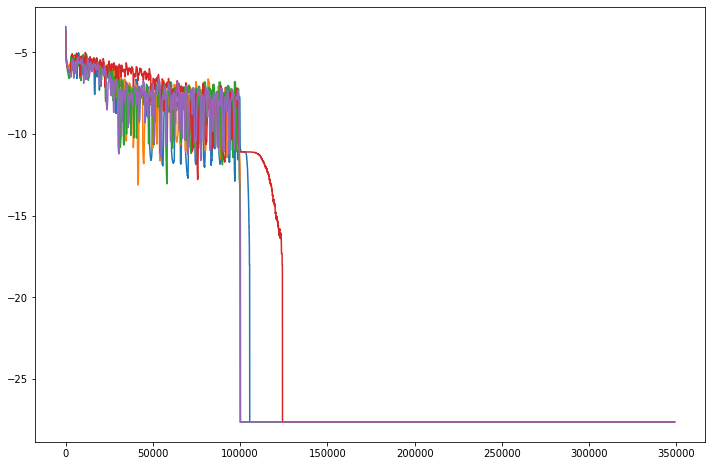

In [397]:
gelu_add_sub = partial(GenAddSubWithActivation, activation=nn.GELU)
model, optim, maes, mses = experiment(gelu_add_sub, add_only=True)

#---------RESULTS---------#
#-Last 1000 epochs avg MAE-#


Trial 1 avg MAE: 1.4711740448092314e-07


Trial 2 avg MAE: 1.745543585229825e-07


Trial 3 avg MAE: 5.916082841395109e-07


Trial 4 avg MAE: 3.746702986973105e-06


Trial 5 avg MAE: 1.715194315465851e-07


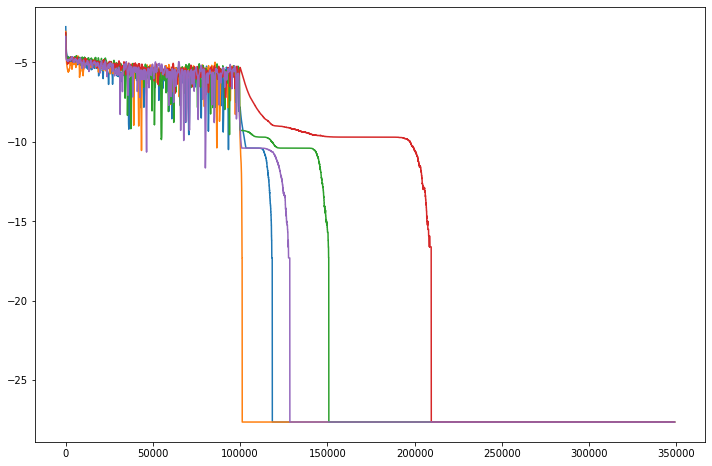

In [398]:
model, optim, maes, mses = experiment(gelu_add_sub, add_only=False)